In [2]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import scipy as sp
from pyrtid.inverse import minimize_lbfgsb
from pyrtid.utils import NDArrayFloat, finite_gradient, indices_to_node_number

- Set-up logging level

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions


In [4]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.1
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [5]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [6]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

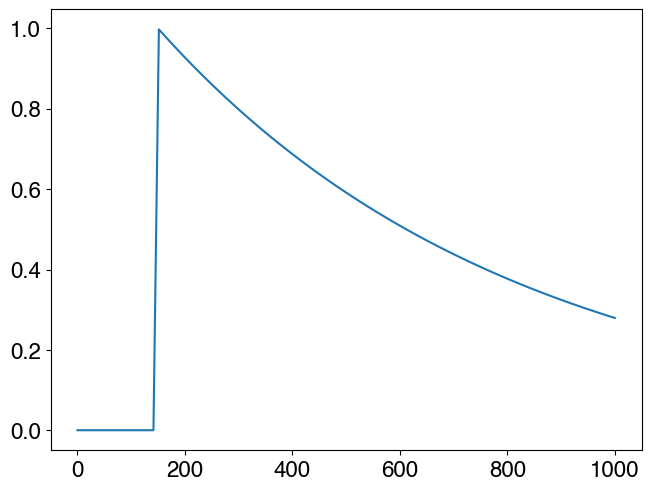

In [11]:
def exp_fun(x: NDArrayFloat, x0: float, rate: float) -> NDArrayFloat:
    return np.where(x > x0, np.exp((x - x0) * rate), 0.0)


_x = np.linspace(0, 1000, 100)
plt.plot(_x, exp_fun(_x, 150, -0.0015))

- Create an image with two circles for denoising

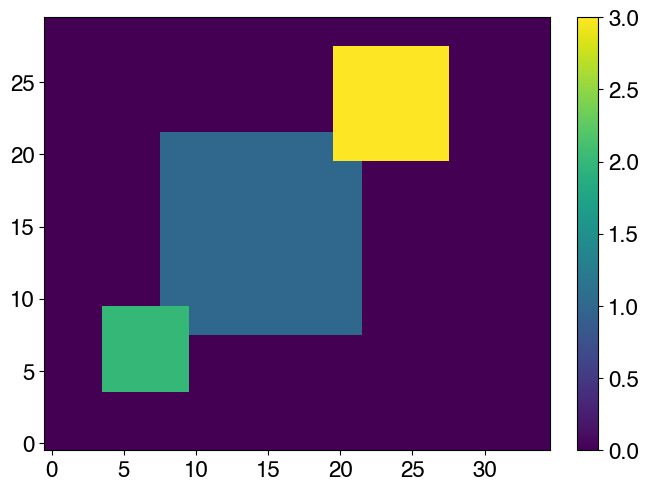

In [6]:
nx = 35
ny = 30

exact_data = np.zeros((nx, ny))
exact_data[8:22, 8:22] = 1.0
exact_data[4:10, 4:10] = 2.0
exact_data[20:28, 20:28] = 3.0

plt.imshow(exact_data.T, origin="lower")
plt.colorbar()

- Create a transformation matrix and a sampler

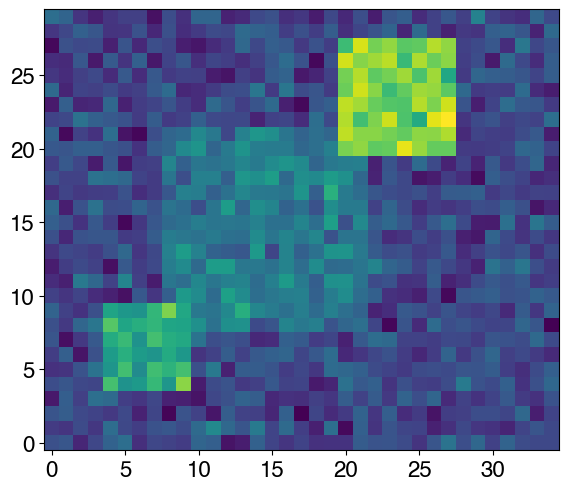

In [7]:
A = np.random.default_rng(2023).normal(loc=3.0, scale=5, size=(nx * ny, nx * ny))
A.flat[:: nx * ny + 1] += 350
res = A @ exact_data.ravel("F")

plt.imshow(res.reshape(nx, ny, order="F").T, origin="lower")

- Observation positions

In [8]:
d_obs = np.arange(2, nx, 5)
d_obs
# indices_to_node_number

array([ 2,  7, 12, 17, 22, 27, 32])

In [9]:
y_obs = np.arange(5, ny, 5)
y_obs

array([ 5, 10, 15, 20, 25])

In [10]:
X, Y = np.meshgrid(d_obs, y_obs)
X, Y

(array([[ 2,  7, 12, 17, 22, 27, 32],
        [ 2,  7, 12, 17, 22, 27, 32],
        [ 2,  7, 12, 17, 22, 27, 32],
        [ 2,  7, 12, 17, 22, 27, 32],
        [ 2,  7, 12, 17, 22, 27, 32]]),
 array([[ 5,  5,  5,  5,  5,  5,  5],
        [10, 10, 10, 10, 10, 10, 10],
        [15, 15, 15, 15, 15, 15, 15],
        [20, 20, 20, 20, 20, 20, 20],
        [25, 25, 25, 25, 25, 25, 25]]))

In [11]:
obs_pos = indices_to_node_number(X, nx, Y).ravel()
obs_pos

array([177, 182, 187, 192, 197, 202, 207, 352, 357, 362, 367, 372, 377,
       382, 527, 532, 537, 542, 547, 552, 557, 702, 707, 712, 717, 722,
       727, 732, 877, 882, 887, 892, 897, 902, 907])

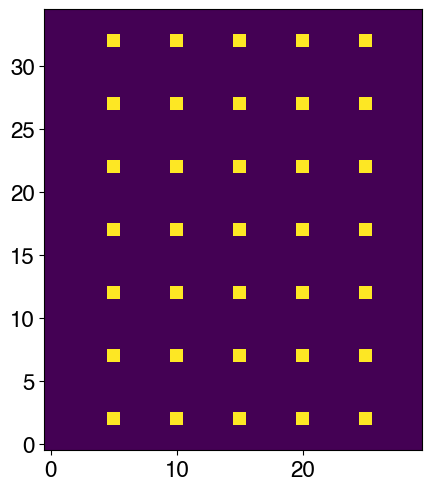

In [12]:
grid_mask = np.zeros((nx * ny))
grid_mask[obs_pos] = 1.0
grid_mask = grid_mask.reshape((nx, ny), order="F")
plt.imshow(grid_mask, origin="lower")

- Create a sampler

In [13]:
Z = np.zeros_like(A)
Z.flat[:: nx * ny + 1] = 1.0
Z = Z[obs_pos]
Z.shape

(35, 1050)

In [14]:
test = Z @ np.arange(nx * ny)
test

array([177., 182., 187., 192., 197., 202., 207., 352., 357., 362., 367.,
       372., 377., 382., 527., 532., 537., 542., 547., 552., 557., 702.,
       707., 712., 717., 722., 727., 732., 877., 882., 887., 892., 897.,
       902., 907.])

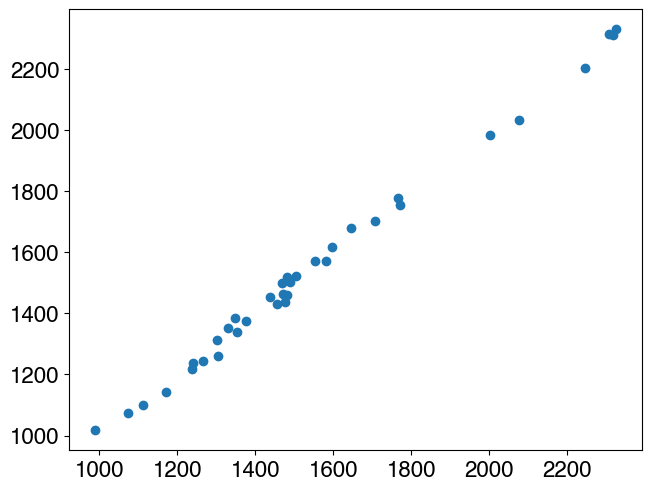

In [15]:
noise_std = 25.0
d_obs_no_noise = Z @ A @ exact_data.ravel("F")
d_obs = d_obs_no_noise + np.random.default_rng(2024).normal(
    loc=0.0, scale=noise_std, size=d_obs_no_noise.size
)

plt.plot(d_obs, d_obs_no_noise, marker="o", linestyle="none")

- Define noisy and not noisy starting points

In [16]:
initial_guess = np.ones((nx, ny))

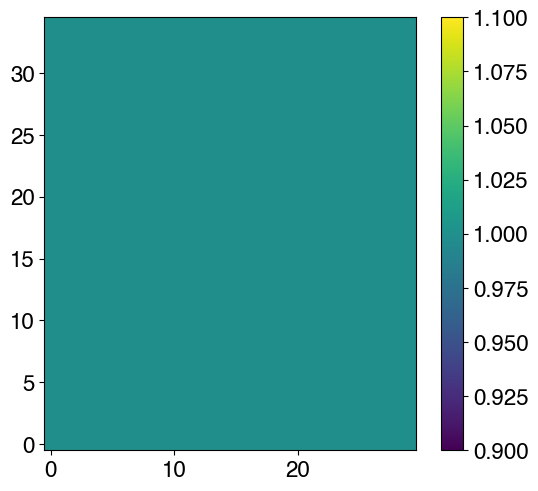

In [17]:
plt.imshow(initial_guess, origin="lower")
plt.colorbar()

- Define objective functions

In [18]:
def J_LS(s: NDArrayFloat) -> float:
    return 0.5 * float(np.sum(((Z @ A @ s - d_obs) / noise_std) ** 2))


reg = pyrtid.inverse.regularization.TVRegularizator(1.0, 1.0)


def loss_reg(s: NDArrayFloat) -> float:
    return reg.eval_loss(s.reshape(nx, ny, order="F"))


def J(s: NDArrayFloat, alpha: float) -> float:
    return J_LS(s) + alpha * loss_reg(s)


def dJ_LS(s: NDArrayFloat) -> NDArrayFloat:
    return A.T @ Z.T @ (Z @ A @ s - d_obs) / noise_std**2


def dloss_reg(s: NDArrayFloat) -> NDArrayFloat:
    return reg.eval_loss_gradient(s.reshape(nx, ny, order="F")).ravel("F")


def dJ(s: NDArrayFloat, alpha: float) -> NDArrayFloat:
    return dJ_LS(s) + alpha * dloss_reg(s)

In [19]:
fd_grad = finite_gradient(initial_guess.ravel("F"), J, fm_kwargs={"alpha": 100.0})

In [20]:
adj_grad = dJ(initial_guess.ravel("F"), alpha=100.0)
np.testing.assert_allclose(fd_grad, adj_grad, rtol=1e-5)

In [21]:
alphas = np.logspace(0, 4, 20, base=10)
alphas

array([1.00000000e+00, 1.62377674e+00, 2.63665090e+00, 4.28133240e+00,
       6.95192796e+00, 1.12883789e+01, 1.83298071e+01, 2.97635144e+01,
       4.83293024e+01, 7.84759970e+01, 1.27427499e+02, 2.06913808e+02,
       3.35981829e+02, 5.45559478e+02, 8.85866790e+02, 1.43844989e+03,
       2.33572147e+03, 3.79269019e+03, 6.15848211e+03, 1.00000000e+04])

In [22]:
res_x_list = []
J_LS_list = []
loss_reg_list = []
for alpha in alphas:
    print(alpha)

    def wrap_J(s: NDArrayFloat) -> float:
        return J(s, alpha)

    def wrap_dJ(s: NDArrayFloat) -> NDArrayFloat:
        return dJ(s, alpha)

    # res_x_list.append(sp.optimize.minimize(method="l-bfgs-b", x0=initial_guess.ravel("F"), fun=wrap_J, jac=wrap_dJ).x)
    res_x_list.append(
        minimize_lbfgsb(x0=initial_guess.ravel("F"), fun=wrap_J, jac=wrap_dJ).x
    )
    J_LS_list.append(J_LS(res_x_list[-1]))
    loss_reg_list.append(loss_reg(res_x_list[-1]))

1.0


1.6237767391887217
2.636650898730358
4.281332398719393
6.951927961775605
11.28837891684689
18.329807108324356
29.76351441631318
48.32930238571752
78.47599703514611
127.42749857031335
206.913808111479
335.9818286283781
545.5594781168514
885.8667904100823
1438.449888287663
2335.7214690901214
3792.690190732246
6158.48211066026
10000.0


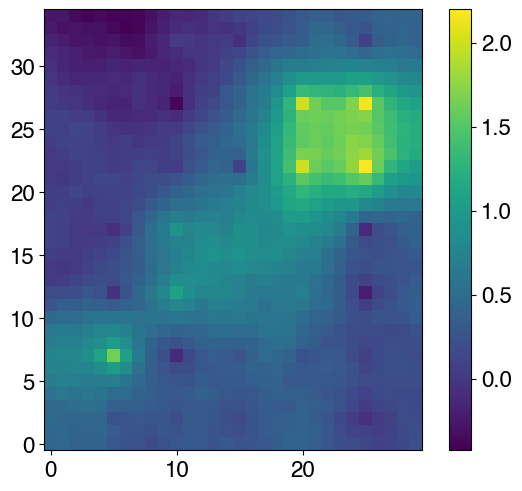

In [23]:
plt.imshow(res_x_list[11].reshape(nx, ny, order="F"), origin="lower")
plt.colorbar()

- Plot the L-curve

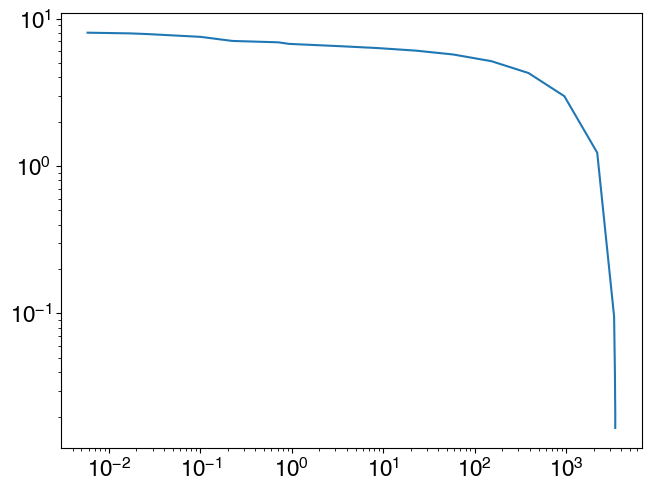

In [24]:
plt.loglog(J_LS_list, loss_reg_list)
# plt.loglog(J_LS_list[32], loss_reg_list[32], marker="o")

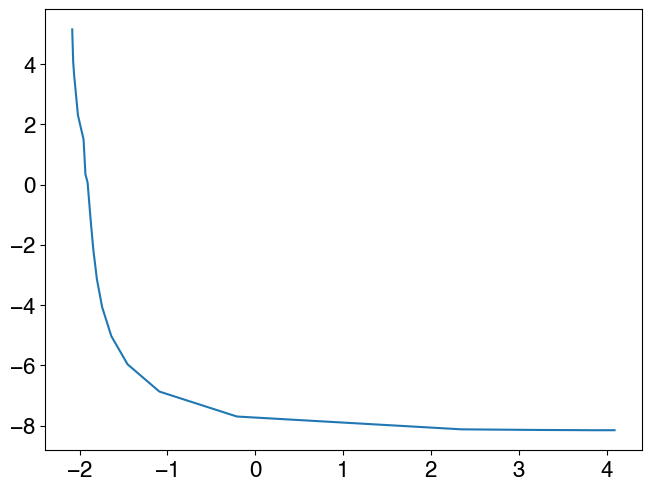

In [25]:
plt.plot(-np.log(loss_reg_list), -np.log(J_LS_list))

- U-curve

In [26]:
u = 1 / np.array(J_LS_list) + 1 / np.array(loss_reg_list)
u_argmin = np.argmin(u)
print(f"u_argmin = {u_argmin}")
print(f"alphas[u_argmin] = {alphas[u_argmin]}")

u_argmin = 10
alphas[u_argmin] = 127.42749857031335


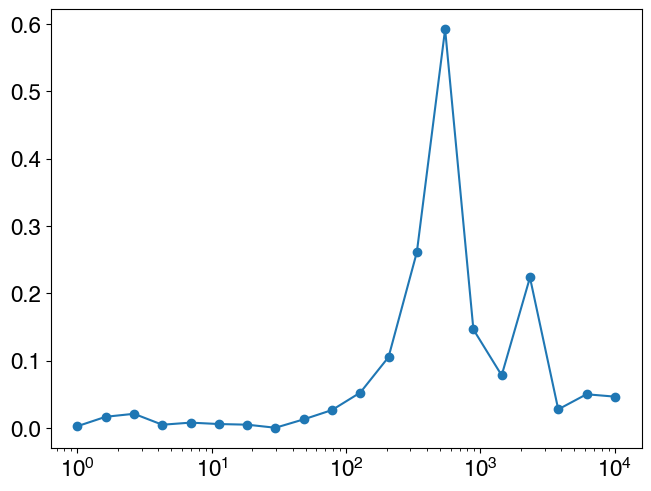

In [27]:
def get_curvature(x: NDArrayFloat, y: NDArrayFloat) -> NDArrayFloat:
    dxdt = np.gradient(x)
    dydt = np.gradient(y)
    velocity = np.vstack([dxdt, dydt]).T
    speed = np.sqrt(dxdt**2 + dydt**2)

    tangent = np.array([1 / speed]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    ss_t = np.gradient(speed)
    xx_t = np.gradient(dxdt)
    yy_t = np.gradient(dydt)

    curvature_val = (
        np.abs(xx_t * dydt - dxdt * yy_t) / (dxdt * dxdt + dydt * dydt) ** 1.5
    )

    return curvature_val


# For the tests
# coordinates = np.array(
#     [[1, 1], [1.5, 2], [2, 3], [2.5, 3.5], [3, 4], [3.5, 4.25], [4, 4.5]]
# )
# curvature = get_curvature(coordinates[:, 0], coordinates[:, 1])
lcurve_loglog_curvature = get_curvature(np.log(J_LS_list), np.log(loss_reg_list))
l_argmin = np.argmax(lcurve_loglog_curvature)
plt.semilogx(alphas, lcurve_loglog_curvature, marker="o")

In [28]:
print(f"l_argmin = {l_argmin}")
print(f"alphas[l_argmin] = {alphas[l_argmin]}")

l_argmin = 13
alphas[l_argmin] = 545.5594781168514


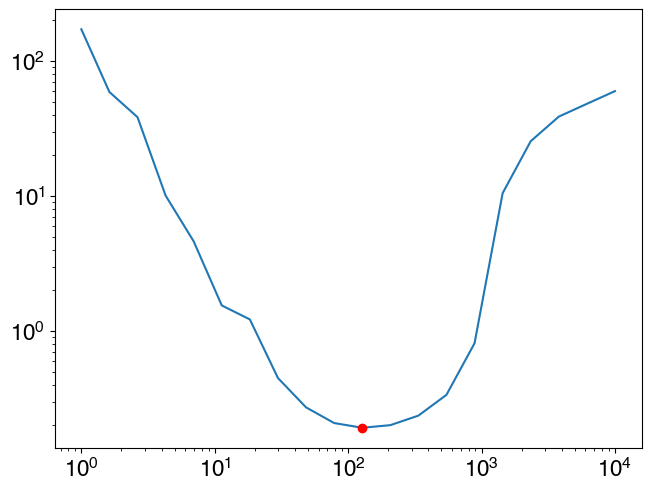

In [29]:
plt.loglog(alphas, 1 / np.array(J_LS_list) + 1 / np.array(loss_reg_list))
plt.loglog(alphas[u_argmin], u[u_argmin], linestyle="None", marker="o", c="r")

In [30]:
model_error = np.sum(
    np.square(np.array(res_x_list) - exact_data.ravel("F")), axis=-1
) / np.linalg.norm(exact_data)

In [31]:
true_noise_level = J_LS(exact_data.ravel("F"))
print(f"true_noise_level = {true_noise_level}")

n_obs = d_obs.size
conf_interval_upper = 0.5 * n_obs + 2 * np.sqrt(0.5 * n_obs)
conf_interval_lower = 0.5 * n_obs - 2 * np.sqrt(0.5 * n_obs)

dp_argmin = np.flatnonzero(np.array(J_LS_list) < 0.5 * n_obs)[-1]

true_noise_level = 14.964497947401478


INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol J from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUni

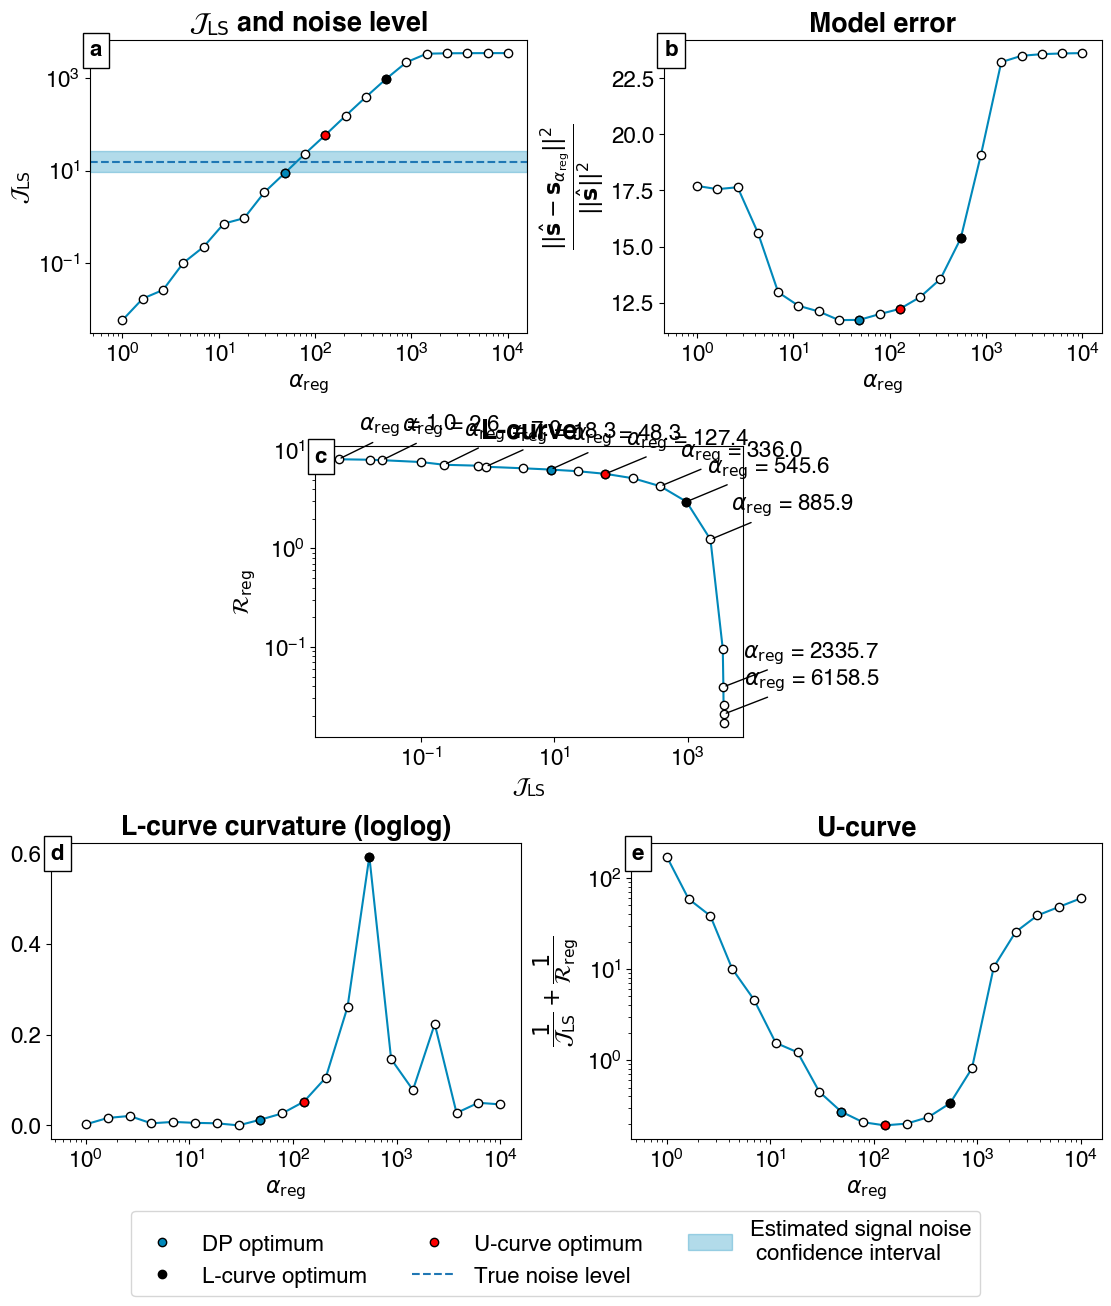

In [32]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 12)},
    subfigs_params={"nrows": 3},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"]],
            sharey=False,
            sharex=True,
        ),
        "fig1": dict(
            mosaic=[["ghost1", "ax2-1", "ghost2"]],
            width_ratios=[0.5, 1.0, 0.5],
            sharey=False,
            sharex=False,
        ),
        "fig2": dict(
            mosaic=[["ax3-1", "ax3-2"]],
            sharey=False,
            sharex=True,
        ),
    },
)

# define a color
my_blue = "#0088ba"

curve_kwargs = dict(marker="o", mec="k", mfc="white", color=my_blue)
dp_point_kwargs = dict(
    linestyle="None", marker="o", c=my_blue, label="DP optimum", mec="k"
)
lc_point_kwargs = dict(
    linestyle="None", marker="o", c="k", label="L-curve optimum", mec="k"
)
uc_point_kwargs = dict(
    linestyle="None", marker="o", c="r", label="U-curve optimum", mec="k"
)

# 1) J_LS
ax = plotter.get_axis("ax1-1")
ax.loglog(alphas, J_LS_list, **curve_kwargs)
ax.semilogx(alphas[dp_argmin], J_LS_list[dp_argmin], **dp_point_kwargs)
ax.semilogx(alphas[l_argmin], J_LS_list[l_argmin], **lc_point_kwargs)
ax.semilogx(alphas[u_argmin], J_LS_list[u_argmin], **uc_point_kwargs)
ax.set_xlabel(r"$\alpha_{\mathrm{reg}}$")
ax.set_ylabel(r"$\mathcal{J}_{\mathrm{LS}}$")
# add handle to legend items
ax.axhline(true_noise_level, linestyle="--", label="True noise level")
handle = ax.axhspan(
    ymin=conf_interval_lower, ymax=conf_interval_upper, color=my_blue, alpha=0.3
)
plotter.add_extra_legend_item(
    "ax1-1", handle, "Estimated signal noise\n confidence interval"
)
ax.set_title(r"$\mathcal{J}_{\mathrm{LS}}$ and noise level", fontweight="bold")
# handle = ax.fill_between(alphas, np.ones_like(alphas) * conf_interval_lower, np.ones_like(alphas) * conf_interval_upper, alpha=0.2)

# 2) Model error
ax = plotter.get_axis("ax1-2")
ax.semilogx(alphas, model_error, **curve_kwargs)
ax.semilogx(alphas[dp_argmin], model_error[dp_argmin], **dp_point_kwargs)
ax.semilogx(alphas[l_argmin], model_error[l_argmin], **lc_point_kwargs)
ax.semilogx(alphas[u_argmin], model_error[u_argmin], **uc_point_kwargs)
ax.set_xlabel(r"$\alpha_{\mathrm{reg}}$")
ax.set_ylabel(
    r"$\dfrac{||\hat{\mathbf{s}} - \mathbf{s}_{\alpha_{\mathrm{reg}}}||^2}{||\hat{\mathbf{s}}||^2}}$"
)
ax.set_title(r"Model error", fontweight="bold")

# 3) L-curve
ax = plotter.get_axis("ax2-1")
ax.loglog(J_LS_list, loss_reg_list, **curve_kwargs)
ax.loglog(J_LS_list[dp_argmin], loss_reg_list[dp_argmin], **dp_point_kwargs)
ax.loglog(J_LS_list[l_argmin], loss_reg_list[l_argmin], **lc_point_kwargs)
ax.loglog(J_LS_list[u_argmin], loss_reg_list[u_argmin], **uc_point_kwargs)
ax.set_xlabel(r"$\mathcal{J}_{\mathrm{LS}}$")
ax.set_ylabel(r"$\mathcal{R}_{\mathrm{reg}}$")
ax.set_title(r"L-curve", fontweight="bold")

for i, (x, y) in enumerate(zip(J_LS_list, loss_reg_list)):
    if i % 2 == 1 and i not in [dp_argmin, l_argmin, u_argmin]:
        continue
    # ax.text(x * 1.2, y * 1.2, rf"$\alpha_{{\mathrm{{reg}}}}$ = {alphas[i]:.1f}",)
    ax.annotate(
        rf"$\alpha_{{\mathrm{{reg}}}}$ = {alphas[i]:.1f}",
        (x, y),
        xytext=(x * 2, y * 2),
        arrowprops=dict(arrowstyle="-"),
    )

# Hide ghost axes
for _ in ["ghost1", "ghost2"]:
    ngp.hide_axis_spine(plotter.get_axis(_), loc="all")
    ngp.hide_axis_ticklabels(plotter.get_axis(_))

# 4) Curvature
ax = plotter.get_axis("ax3-1")
ax.semilogx(alphas, lcurve_loglog_curvature, **curve_kwargs)
ax.semilogx(alphas[dp_argmin], lcurve_loglog_curvature[dp_argmin], **dp_point_kwargs)
ax.semilogx(alphas[l_argmin], lcurve_loglog_curvature[l_argmin], **lc_point_kwargs)
ax.semilogx(alphas[u_argmin], lcurve_loglog_curvature[u_argmin], **uc_point_kwargs)
ax.set_xlabel(r"$\alpha_{\mathrm{reg}}$")
ax.set_title(r"L-curve curvature (loglog)", fontweight="bold")

# 5) U-curve
ax = plotter.get_axis("ax3-2")
ax.loglog(alphas, u, **curve_kwargs)
ax.loglog(alphas[dp_argmin], u[dp_argmin], **dp_point_kwargs)
ax.loglog(alphas[l_argmin], u[l_argmin], **lc_point_kwargs)
ax.loglog(alphas[u_argmin], u[u_argmin], **uc_point_kwargs)
ax.set_xlabel(r"$\alpha_{\mathrm{reg}}$")
ax.set_ylabel(
    r"$\dfrac{1}{\mathcal{J}_{\mathrm{LS}}} + \dfrac{1}{\mathcal{R}_{\mathrm{reg}}}$"
)
ax.set_title(r"U-curve", fontweight="bold")

plotter.add_fig_legend(ncols=3, bbox_y_shift=0.01)

ngp.add_letter_to_frames(
    plotter.get_axes(["ax1-1", "ax1-2", "ax2-1", "ax3-1", "ax3-2"])
)

# prevent overlapping between the fame letter and data
for ax in plotter.axes:
    _lims = ax.get_xlim()
    ax.set_xlim(_lims[0] * 0.85, _lims[1])

fname = fig_save_path.joinpath("lcurve_vs_ucurve")
for format in ["png", "pdf", "svg"]:
    plotter.savefig(
        fig_save_path.joinpath(f"{fname}.{format}"),
        format=format,
    )

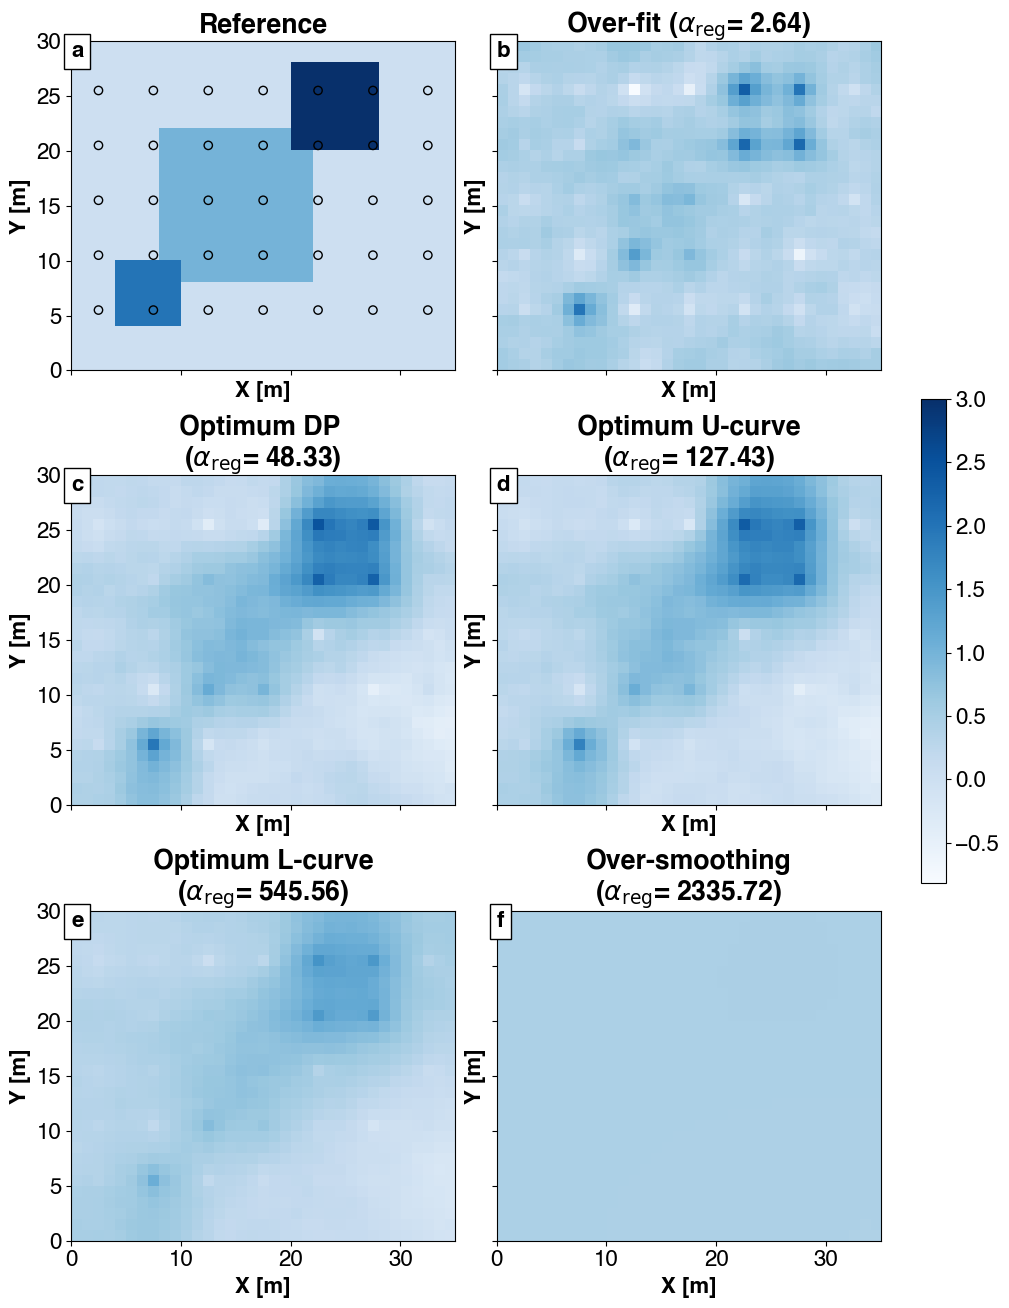

In [44]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 13)},
    # subfigs_params={"nrows":3},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"], ["ax3-1", "ax3-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

data = {
    "Reference": exact_data,
    r"Over-fit ($\alpha_{{\mathrm{reg}}}}$" + f"= {alphas[2]:.2f})": res_x_list[2],
    "Optimum DP \n"
    + r"($\alpha_{{\mathrm{reg}}}}$"
    + f"= {alphas[dp_argmin]:.2f})": res_x_list[dp_argmin],
    "Optimum U-curve\n"
    + r"($\alpha_{{\mathrm{reg}}}}$"
    + f"= {alphas[u_argmin]:.2f})": res_x_list[u_argmin],
    "Optimum L-curve\n"
    + r"($\alpha_{{\mathrm{reg}}}}$"
    + f"= {alphas[l_argmin]:.2f})": res_x_list[l_argmin],
    "Over-smoothing\n"
    + r"($\alpha_{{\mathrm{reg}}}}$"
    + f"= {alphas[16]:.2f})": res_x_list[16],
}

ngp.add_letter_to_frames(plotter.axes)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={k: v.reshape(nx, ny, order="F") for k, v in data.items()},
    # cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("Blues"),
        "extent": [0.0, nx, 0.0, ny],
        "aspect": "equal",
        # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    cbar_kwargs={"shrink": 0.4},
)

# Add wells location
plotter.axes[0].scatter(X + 0.5, Y + 0.5, marker="o", facecolor="none", edgecolors="k")

fname = fig_save_path.joinpath("maps_6_res_linear_case")
for format in ["png", "pdf"]:
    plotter.savefig(
        fig_save_path.joinpath(f"{fname}.{format}"),
        format=format,
    )

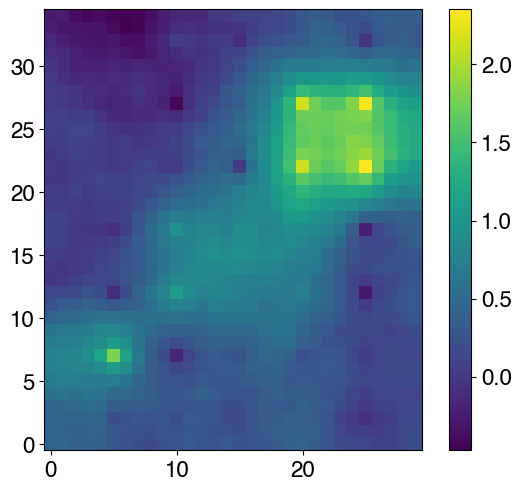

In [34]:
plt.imshow(res_x_list[u_argmin].reshape(nx, ny, order="F"), origin="lower")
plt.colorbar()

In [35]:
alphas[u_argmin]

127.42749857031335

In [36]:
loss_reg_list[u_argmin] * alphas[u_argmin]

727.7371756704663

In [37]:
J_LS_list[u_argmin]

58.4401180491037

Nos tests nous ont néanmoins montré qu'en utilisant une U-curve, le lambda optimal ne correspond pas au niveau de bruit mais à une valeur jusqu'à 1 ordre de grandeur supérieure.
Le problème qui se pose est que le redémarrafe nécessite également un calcul de la fonction objective précédente afin de calculer correctement le taux de décroissance de la fonction qui est l'un des critères d'arrêt. Autrement, l'augmentation brutale du alpha conduit à un arrêt prématuré du solveur.

Le niveau de bruit peu donc être estimé comme le nombre d'observation * 2.

En pratique, il vaut mieux un niveau de bruit trop élevé, quitte à redémarrer la résolution. Dans HYTEC, nous avons codé la possibilité de restaurer les paramètres et les gradients passés qui sont écrit sur disque. Ainsi, le redémarrage n'affecte pas la qualité de l'estimation du Hessien. La convergence avec un nouveau niveau de bruit peu alors être assurée rapidement.

dobs.size

$\rightarrow 0$

# Trial with an adaptative strategy

In [38]:
noise_level = true_noise_level * 10
noise_level

149.64497947401478

In [39]:
import copy
from typing import Deque, List, Tuple

from pyrtid.inverse.regularization.adaptive import get_optimal_reg_param


class Optimizer:
    def __init__(self, noise_level: float) -> None:
        """Initialize the instance."""
        # regularization weight
        self.alphas: List[float] = []
        self.alpha: float = 1.0
        self.j_ls_list: List[float] = []
        self.loss_reg_list: List[float] = []
        self.it = 0
        self.noise_level: float = noise_level
        self.is_nl_reached: float = False

    def J(self, s: NDArrayFloat) -> float:
        self.it += 1
        j_ls = J_LS(s)
        self.j_ls_list.append(j_ls)
        loss_reg = loss_reg(s)
        self.loss_reg_list.append(loss_reg)
        # store the alphas
        self.alphas.append(self.alpha)
        print(f"\nit = {self.it}")
        print(f"J_ls = {j_ls}")
        print(f"loss_reg = {loss_reg}")
        return j_ls + loss_reg * self.alpha

    def dJ(self, s: NDArrayFloat) -> NDArrayFloat:
        return dJ(s, self.alpha)

    @property
    def uc_values(self) -> NDArrayFloat:
        """Return the u-curve values."""
        return 1 / np.array(self.j_ls_list) + 1 / np.array(self.loss_reg_list)

    def update_alpha(
        self,
        s: NDArrayFloat,
        j: float,
        j_old: float,
        grad: NDArrayFloat,
        X: Deque[NDArrayFloat],
        G: Deque[NDArrayFloat],
    ) -> Tuple[float, float, NDArrayFloat, Deque[NDArrayFloat]]:
        old_alpha = copy.copy(self.alpha)
        # alpha is choosen so that loss_reg == J_LS
        loss_reg = loss_reg(s)
        # note s is not stored in X yet.
        loss_reg_old = loss_reg(X[-1])

        # compute j_ls by substrating loss_reg with the old alpha
        j_ls = j - old_alpha * loss_reg

        if j_ls < self.noise_level or self.is_nl_reached:
            # set the noise level as reached
            self.is_nl_reached = True

            # Alors on optimize une fonction convexe the la U-curve
            self.alpha = get_optimal_reg_param()
            # TODO: cas de la première itération
            print("optimizing alpha")
            # self.alpha = self.alphas[np.argmin(1 / np.array(self.j_ls_list) + 1 / np.array(self.loss_reg_list))]
        else:
            self.alpha = j_ls / loss_reg

        # return j, grad, G

        print(f"old_alpha =   {old_alpha}")
        print(f"new_alpha =   {self.alpha}")

        # update j
        new_j = j_ls + self.alpha * loss_reg
        new_j_old = j_old + (self.alpha - old_alpha) * loss_reg_old

        print(f"old_f0 =      {j_old}")
        print(f"new_olf_f0 =  {new_j_old}")

        # now update the gradient
        dloss_reg = dloss_reg(s)
        new_grad = grad + (self.alpha - old_alpha) * dloss_reg

        # Update grad_deque
        for _x in X:
            # we remove the reg part with the old weight and add it back with the
            # new one
            # Note: get_loss_reg_function_gradient is very fast to obtain
            G.append((G.popleft() + (self.alpha - old_alpha) * dloss_reg(_x)))

        print(new_j_old - new_j)

        # this is a hack of the lbfgsb, we modify the function
        if new_j_old - new_j < 0:
            new_j_old = new_j + np.abs(j_ls - (j_old - old_alpha * loss_reg_old))

        return new_j, new_j_old, new_grad, G


optimizer = Optimizer(noise_level)
res = minimize_lbfgsb(
    x0=initial_guess.ravel("F"),
    fun=optimizer.J,
    jac=optimizer.dJ,
    update_fun_def=optimizer.update_alpha,
    ftol=0.01,
)
res

UnboundLocalError: cannot access local variable 'loss_reg' where it is not associated with a value

In [ ]:
sorted_alphas = np.array(
    [
        1.00000000e00,
        4.78152428e01,
        1.77563588e02,
        1.02207595e03,
        7.65125427e03,
        9.95692957e03,
    ]
)
sorted_uc_values = np.array(
    [0.16987166, 0.20260699, 0.14189685, 0.17387793, 0.21383609, 0.2119825]
)

sorted_alphas = np.array(
    [
        27.35359161,
        30.30652248,
        35.29225981,
        39.38447388,
        47.81524279,
        69.17092301,
        72.93661981,
        75.79956511,
        202.50923043,
        203.85818656,
        205.17848985,
        238.42254234,
        251.9735611,
        474.7147755,
        583.65331837,
        585.96855307,
        739.89857569,
        2154.20686131,
    ]
)
sorted_uc_values = np.array(
    [
        0.33351232,
        0.31170122,
        0.27644231,
        0.2584534,
        0.20260699,
        0.21570768,
        0.18943646,
        0.17845677,
        0.17798118,
        0.1405242,
        0.18920538,
        0.17938885,
        0.18937385,
        0.18443753,
        0.25353631,
        0.26236171,
        0.27918773,
        0.33547961,
    ]
)

sorted_alphas = np.array(
    [47.81524279, 177.56358807, 209.88755336, 220.87120974, 1022.0759485, 7651.25426679]
)
sorted_uc_values = np.array(
    [0.20260699, 0.14189685, 0.14105013, 0.15775547, 0.17387793, 0.21383609]
)

id_min_uc = np.argmin(sorted_uc_values)
id_min_uc

id_2keep = [id_min_uc]

# going backward from the mininmum
for i in range(id_min_uc):
    j = id_min_uc - i - 1
    if sorted_uc_values[j] > sorted_uc_values[j + 1]:
        id_2keep.insert(0, j)

# going forkward from the mininmum
for i in range(sorted_alphas.size - id_min_uc - 1):
    j = i + id_min_uc + 1
    if sorted_uc_values[j] > sorted_uc_values[j - 1]:
        id_2keep.append(j)

masked_alphas = sorted_alphas[id_2keep]
masked_uc = sorted_uc_values[id_2keep]

print(masked_alphas)
print(masked_uc)

# won't work if the number of element is lower than 4.
k = min(4, len(id_2keep) - 1)
print(f"k = {k}")
# perform a spline interpolation of alpha_reg vs. u-curve values
# work on a log space to ease the process
spl = sp.interpolate.InterpolatedUnivariateSpline(
    np.log(masked_alphas), np.log(masked_uc), k=k
)
# spl =sp.interpolate.interp1d(np.log(masked_alphas), np.log(masked_uc), kind="quadratic")
spl.set_smoothing_factor(10.0)

# if k >= 4:
#     # find critical points = where the spline derivative cancels (minimumns and maximums)
#     cr_pts = spl.derivative().roots()
#     # also check the endpoints of the interval
#     cr_pts = np.append(cr_pts, (np.log(masked_alphas[0]), np.log(masked_alphas[-1])))
#     # evaluate the interpolation at each critical points
#     cr_vals = spl(cr_pts)
#     # find the index of the global mininmum
#     min_index = np.argmin(cr_vals)
#     # return the optimal alpha
#     print(np.exp(cr_pts[min_index]))
# else:
pts = np.logspace(
    np.log10(masked_alphas[0]) + 1e-10, np.log10(masked_alphas[-1]) - 1e-10, base=10
)
print(pts[np.argmin(spl(np.log(pts)))])
print(spl(np.log(pts)))

[  47.81524279  177.56358807  209.88755336  220.87120974 1022.0759485
 7651.25426679]
[0.20260699 0.14189685 0.14105013 0.15775547 0.17387793 0.21383609]
k = 4
3340.940597792805
[-1.59640518 -1.73362552 -1.84343874 -1.92863481 -1.99188121 -2.03572295
 -2.06258257 -2.07476013 -2.07443324 -2.063657   -2.04436407 -2.01836462
 -1.98734636 -1.95287451 -1.91639183 -1.87921861 -1.84255264 -1.80746928
 -1.77492138 -1.74573934 -1.72063107 -1.70018203 -1.68485518 -1.67499102
 -1.67080759 -1.67240043 -1.67974263 -1.69268479 -1.71095505 -1.73415908
 -1.76178007 -1.79317872 -1.82759329 -1.86413954 -1.90181078 -1.93947783
 -1.97588904 -2.00967029 -2.03932499 -2.06323407 -2.07965599 -2.08672675
 -2.08245985 -2.06474634 -2.03135479 -1.97993129 -1.90799947 -1.81296048
 -1.69209299 -1.54255321]


In [ ]:
pts

array([  47.8152428 ,   53.0333853 ,   58.82099079,   65.24020555,
         72.35995794,   80.2566986 ,   89.01522131,   98.72957352,
        109.50406621,  121.45439394,  134.70887719,  149.40984024,
        165.71513938,  183.799858  ,  203.85818657,  226.10550783,
        250.78070953,  278.14874956,  308.50350103,  342.17090783,
        379.51248454,  420.92919832,  466.86577442,  517.81547157,
        574.3253785 ,  637.00228845,  706.51921485,  783.62261802,
        869.14042047,  963.99089706, 1069.19253521, 1185.87497126,
       1315.2911203 , 1458.83062977, 1618.0348012 , 1794.61314046,
       1990.46171412, 2207.68350909, 2448.61101408, 2715.83126549,
       3012.21362649, 3340.94059779, 3705.54199072, 4109.93282971,
       4558.45539115, 5055.92582996, 5607.68589458, 6219.66028575,
       6898.42027484, 7651.25426503])

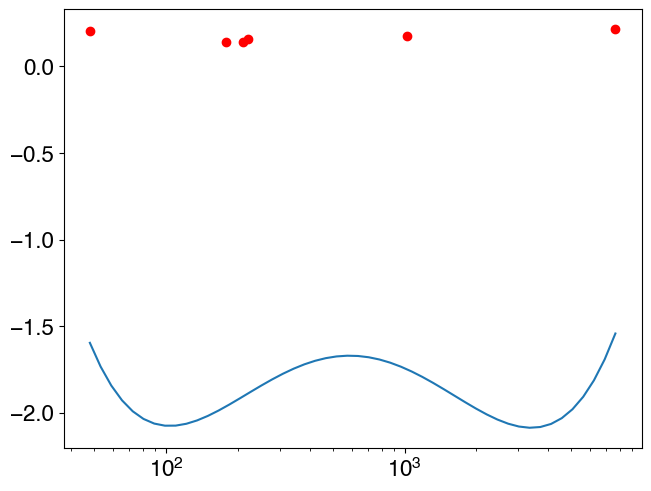

In [ ]:
plt.semilogx(pts, spl(np.log(pts)))
plt.semilogx(masked_alphas, masked_uc, marker="o", c="r", linestyle="none")

In [ ]:
predictions = spl(np.log(pts))
predictions

array([-1.59640518, -1.73362552, -1.84343874, -1.92863481, -1.99188121,
       -2.03572295, -2.06258257, -2.07476013, -2.07443324, -2.063657  ,
       -2.04436407, -2.01836462, -1.98734636, -1.95287451, -1.91639183,
       -1.87921861, -1.84255264, -1.80746928, -1.77492138, -1.74573934,
       -1.72063107, -1.70018203, -1.68485518, -1.67499102, -1.67080759,
       -1.67240043, -1.67974263, -1.69268479, -1.71095505, -1.73415908,
       -1.76178007, -1.79317872, -1.82759329, -1.86413954, -1.90181078,
       -1.93947783, -1.97588904, -2.00967029, -2.03932499, -2.06323407,
       -2.07965599, -2.08672675, -2.08245985, -2.06474634, -2.03135479,
       -1.97993129, -1.90799947, -1.81296048, -1.69209299, -1.54255321])

In [ ]:
get_minimum_id(predictions)

array([ 7, 41])

In [ ]:
d_obs.size

36

In [ ]:
optimizer.alpha

209.8792765418466

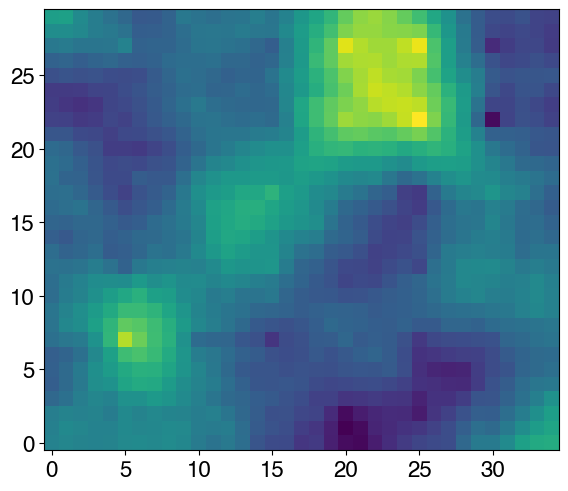

In [ ]:
plt.imshow(res.x.reshape(nx, ny, order="F"), origin="lower")

Une approche empirique très classique est la L-curve. En revanche, dans le cas non-linéaire, il s'agit d'un choix de paramètre à posteriori. On doit donc effectuer plusieurs fois la minimisation pour des valeurs de alpha différentes, sachant que les gammes de valeur de alpha trouvée dans la literature sont très vastes. Il est donc difficile de savoir sur quelle plage de valeur étudier. Des approche adaptative ont été développé mais elle s'intègre directement avec les solveurs et sont assez invasives.

Une alternative plus récente est l'utilisation de la U-curve. L'idée est similaire mais c'est cette fois...

La L-curve est assez difficile à quantifier.
En revanche, une alternative

- Cette approche a fait ses preuves sur plusieurs 